# DOE(Design Of Experiment, 실험계획법)
 - 효율적인 실험 방법을 설계하고 결과제를 제대로 분석하는 것을 목표로 하는 실험 분야
 - 실험의 독립변수 X, 종속변수를 y라고 하자
 - DOE를 진행하기 전에 두가지를 정해야 한다. <br>
   1) Y관한 어떤 모델을 만들고 싶은가(ex number of polynomial terms) <br>
   2) x값의 범위, level <br>
 - 실험계획법은 크게 두가지로 나눌 수 있다. <br>
   1) Screening DOE: 초기 주요 영향변수를 알아내기 위한 실험계획법 <br>
   2) Augment DOE: 추가적인 실험을 진행하기 위한 실험계획법

# Augment DOE

## 1. Mutivariate Bayesian Optimization
 - 모든 실험 영역을 골고루 찾는 것이 아닌, 원하는 최적 타겟 값이 존재할 만한 영역만 찾는 방식
 
 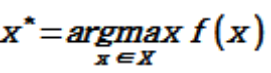
 - 현재까지의 데이터 기반으로 모델을 만들고, 모델의 불확실한 영역을 최소화 + 최적 값이 존재하는 영역을 다음 실험값으로 추천하는 방식이다.  
 - f(x)가 최대인 지점을 찾는 것을 목표라고 해보자. 아래 그림에서 모델의 mean, covariance 값이 큰 위치를 새로운 관측값으로 추가한다. 
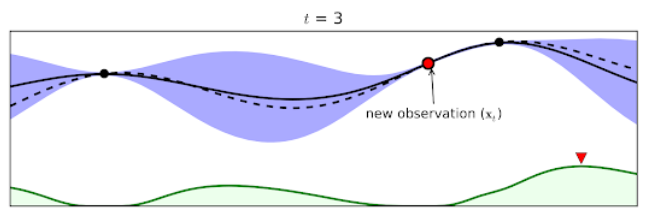

 - 그 다음 mean, covariance가 큰 지점을 또다시 추가하면서 관측값이 전역적인 최적값 위치로 가는것을 볼 수 있음
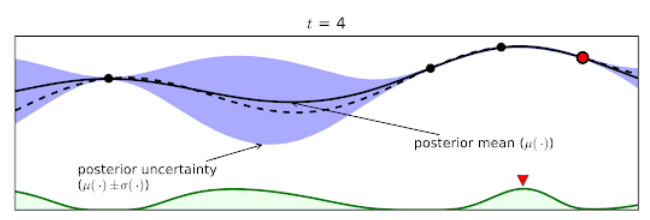
ref: https://sonsnotation.blogspot.com/2020/11/12-bayesian-optimization.html

#### 사용되는 함수
 - surrogate function: 사전 데이터(prior)로 만든 확률 모델 kernel을 무얼 쓰냐에 따라 다양하게 만들 수 있음
 - Acquisition function: 다음 관측치를 선택하기 위한 함수. 위의 그림에서 초록색 그래프

#### 베이지안 최적화  open source

 - SMAC : http://www.cs.ubc.ca/labs/beta/Projects/SMAC/
 - Hyperopt: http://jaberg.github.io/hyperopt/
 - Spearmint: https://github.com/JasperSnoek/spearmint/
 - Bayesopt:  http://rmcantin.bitbucket.org/
 - Bayeso: https://github.com/jungtaekkim/bayeso

# 파이썬으로 다변량 베이지안 최적화 해보기
ref: https://optilog.tistory.com/33

In [29]:
import pandas as pd
import warnings
# 경고창 숨기기
warnings.filterwarnings('ignore') 
from scipy.stats import norm
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF


# 1. Acquisition function
def expected_improvement(mean, std, max):
	z = (mean - max ) / std
	return (mean-max) * norm.cdf(z) + std * norm.pdf(z)

# 2. Objective function
def f(X):	
    x1 = X[:,0]
    x2 = X[:,1]
    return x1 * np.sin(x2)

# 3. Hyper-parameter space
min_x1, max_x1 = -2, 10
min_x2, max_x2 = 6, 7

# 4. Observation Data
num = 10
X1 = np.random.uniform(min_x1, max_x1, num)
X2 = np.random.uniform(min_x2, max_x2, num)
X = np.array([X1,X2]).transpose()
y = f(X).ravel()

data = pd.DataFrame(X)
data.columns = ['x1', 'x2']
data['y'] = y
# 5. Instantiate Gaussian Process model
model = GaussianProcessRegressor(kernel=RBF(1.0))

for i in np.arange(5):
	# 6. Fit to data
    model.fit(X, y)
    
    # 7. Acquisition Function
    x1s = np.random.uniform(min_x1, max_x1, 10000)
    x2s = np.random.uniform(min_x2, max_x2, 10000)
    xs = np.array([x1s, x2s]).transpose()
    mean, std = model.predict(xs, return_std=True)
    acq = expected_improvement(mean, std, y.max())
    
    # 8. Query Objective Function
    x_new = xs[acq.argmax()].reshape(1,-1)
    y_new = f(x_new)
    
    # 9. Augment Data
    X = np.append(X, x_new, axis=0)
    y = np.append(y, np.array([y_new]))

data2 = pd.DataFrame(X[num:])

data2.columns = ['x1', 'x2']
data2['y'] = y[num:]
data2['label'] = 'add'
data['label'] = 'origin'


# 9. Get optimal result
print("Optimal")
print("X: ",X[y.argmax()])
print("y: ",y.max())

Optimal
X:  [6.19433295 6.99492143]
y:  4.0458248171573015


#### 기존 데이터(origin)과 샤로운 추천값(new)를 보면 x1, x2 조건이 적으면서, y를 최대로 하는 포인트를 추천한 것 볼 수 있음

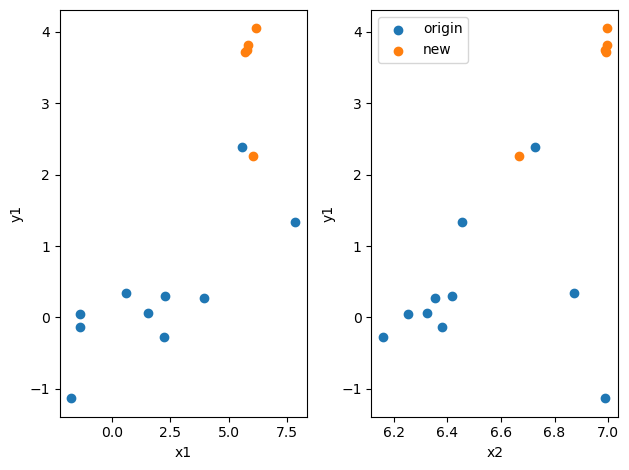

In [41]:
import matplotlib.pyplot as plt
plt.subplot(121)
plt.scatter(data['x1'],data['y'], label='origin')
plt.scatter(data2['x1'],data2['y'], label='new')
plt.xlabel('x1')
plt.ylabel('y1')

plt.subplot(122)
plt.scatter(data['x2'],data['y'], label='origin')
plt.scatter(data2['x2'],data2['y'], label='new')
plt.xlabel('x2')
plt.ylabel('y1')
plt.legend()
plt.tight_layout()